In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset, DataLoader

from src.eval import evaluate
from src.train import train
from src.data import get_dataloaders, get_retain_forget_datasets
from src.forget import sample_from_exact_marginal, estimate_marginal_kl_distance
from src.forget import forget
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

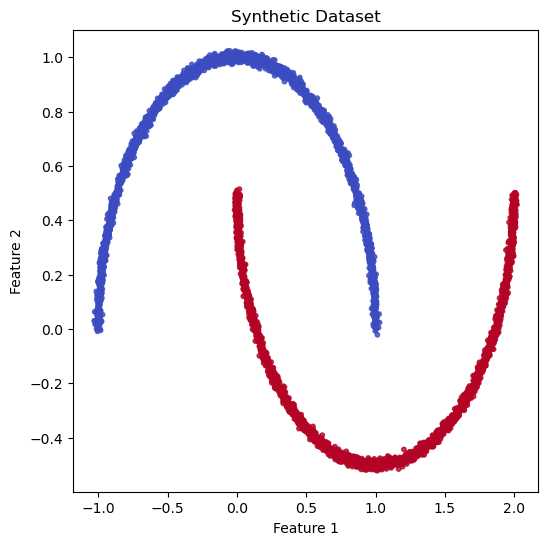

In [2]:
# Generate synthetic data (2D, two classes)
X, y = make_moons(n_samples=5000, noise=0.01, random_state=42)
X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Visualize the dataset
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=10, alpha=0.8)
plt.title("Synthetic Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

dataset = TensorDataset(X, y)

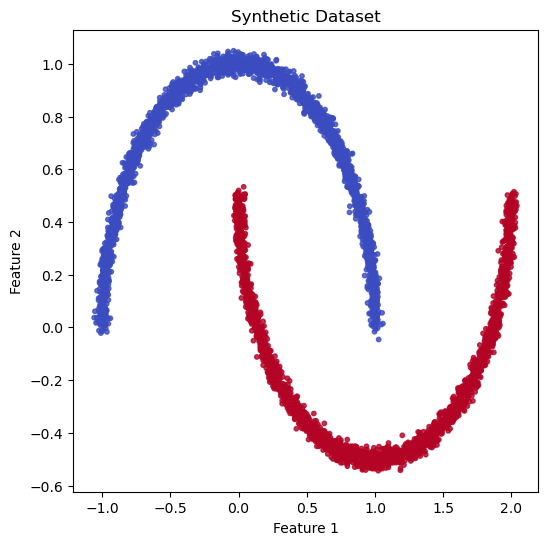

In [3]:
# Generate synthetic data (2D, two classes)
X, y = make_moons(n_samples=5000, noise=0.02, random_state=42)
X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Visualize the dataset
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=10, alpha=0.8)
plt.title("Synthetic Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

surrogate_dataset = TensorDataset(X, y)

In [4]:
# set datasets
train_dataset, test_dataset = get_retain_forget_datasets(dataset, 0.1)
retain_dataset, forget_dataset = get_retain_forget_datasets(train_dataset, 0.1)
train_loader, test_loader = get_dataloaders([train_dataset, test_dataset], batch_size=256)
retain_loader, forget_loader = get_dataloaders([retain_dataset, forget_dataset], batch_size=256)
surrogate_loader = get_dataloaders(surrogate_dataset, batch_size=256) 

In [5]:
#######################################
# 2) MLP CLASSIFIER
#######################################
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)  # Output layer: 2 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize model, optimizer, and loss function
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
def log_eval(model, train_loader, val_loader, retain_loader, forget_loader, surr_loader, criterion, device):
    train_acc = evaluate(train_loader, model, criterion, device=device, log=True)
    test_acc = evaluate(val_loader, model, criterion, device=device, log=True)
    retain_acc = evaluate(retain_loader, model, criterion, device=device, log=True)
    forget_acc = evaluate(forget_loader, model, criterion, device=device, log=True)
    surr_acc = evaluate(surr_loader, model, criterion, device=device, log=True)
    print('train: {}, test: {}, retain: {}, forget: {}, surrogate:{}'.format(train_acc, test_acc, retain_acc, forget_acc, surr_acc))

In [7]:
train(train_loader, test_loader, model, criterion, optimizer, num_epoch=100, device=device)

eval: 100%|██████████| 2/2 [00:00<00:00, 540.68batch/s, acc=1, loss=2.67e-5]


In [8]:
log_eval(model, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)

eval: 100%|██████████| 20/20 [00:00<00:00, 386.19batch/s, acc=1, loss=2.52e-5]

train: 1.0, test: 1.0, retain: 1.0, forget: 1.0, surrogate:1.0


In [9]:
#######################################
# 4) VISUALIZE DECISION BOUNDARY
#######################################
# Create a grid of points in the feature space
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)
)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

In [10]:
T = 5
feature_1_range = (-1, 2) 
feature_2_range = (-0.5, 1) 

# Compute predictions and energy
with torch.no_grad():
    logits = model(grid.to(device))
    probs = torch.softmax(logits, dim=1)
    penalty_mask = (
        (grid[:, 0] >= feature_1_range[0]) & (grid[:, 0] <= feature_1_range[1]) &
        (grid[:, 1] >= feature_2_range[0]) & (grid[:, 1] <= feature_2_range[1])
    )
    
    energy_0 = torch.log(probs[:, 0])
    energy_0[penalty_mask] += 0.5
    energy_0 = energy_0.to('cpu').numpy().reshape(xx.shape)
    
    energy_1 = torch.log(probs[:, 1])
    energy_1[penalty_mask] += 0.5
    energy_1 = energy_1.to('cpu').numpy().reshape(xx.shape)
    
    energy = -1 * T * torch.logsumexp(logits / T, dim=1)
    energy[penalty_mask] += 0.5
    energy = energy.to('cpu').numpy().reshape(xx.shape)
    
    predictions = torch.argmax(probs, dim=1).to('cpu').numpy().reshape(xx.shape)
    
grid = grid.cpu()

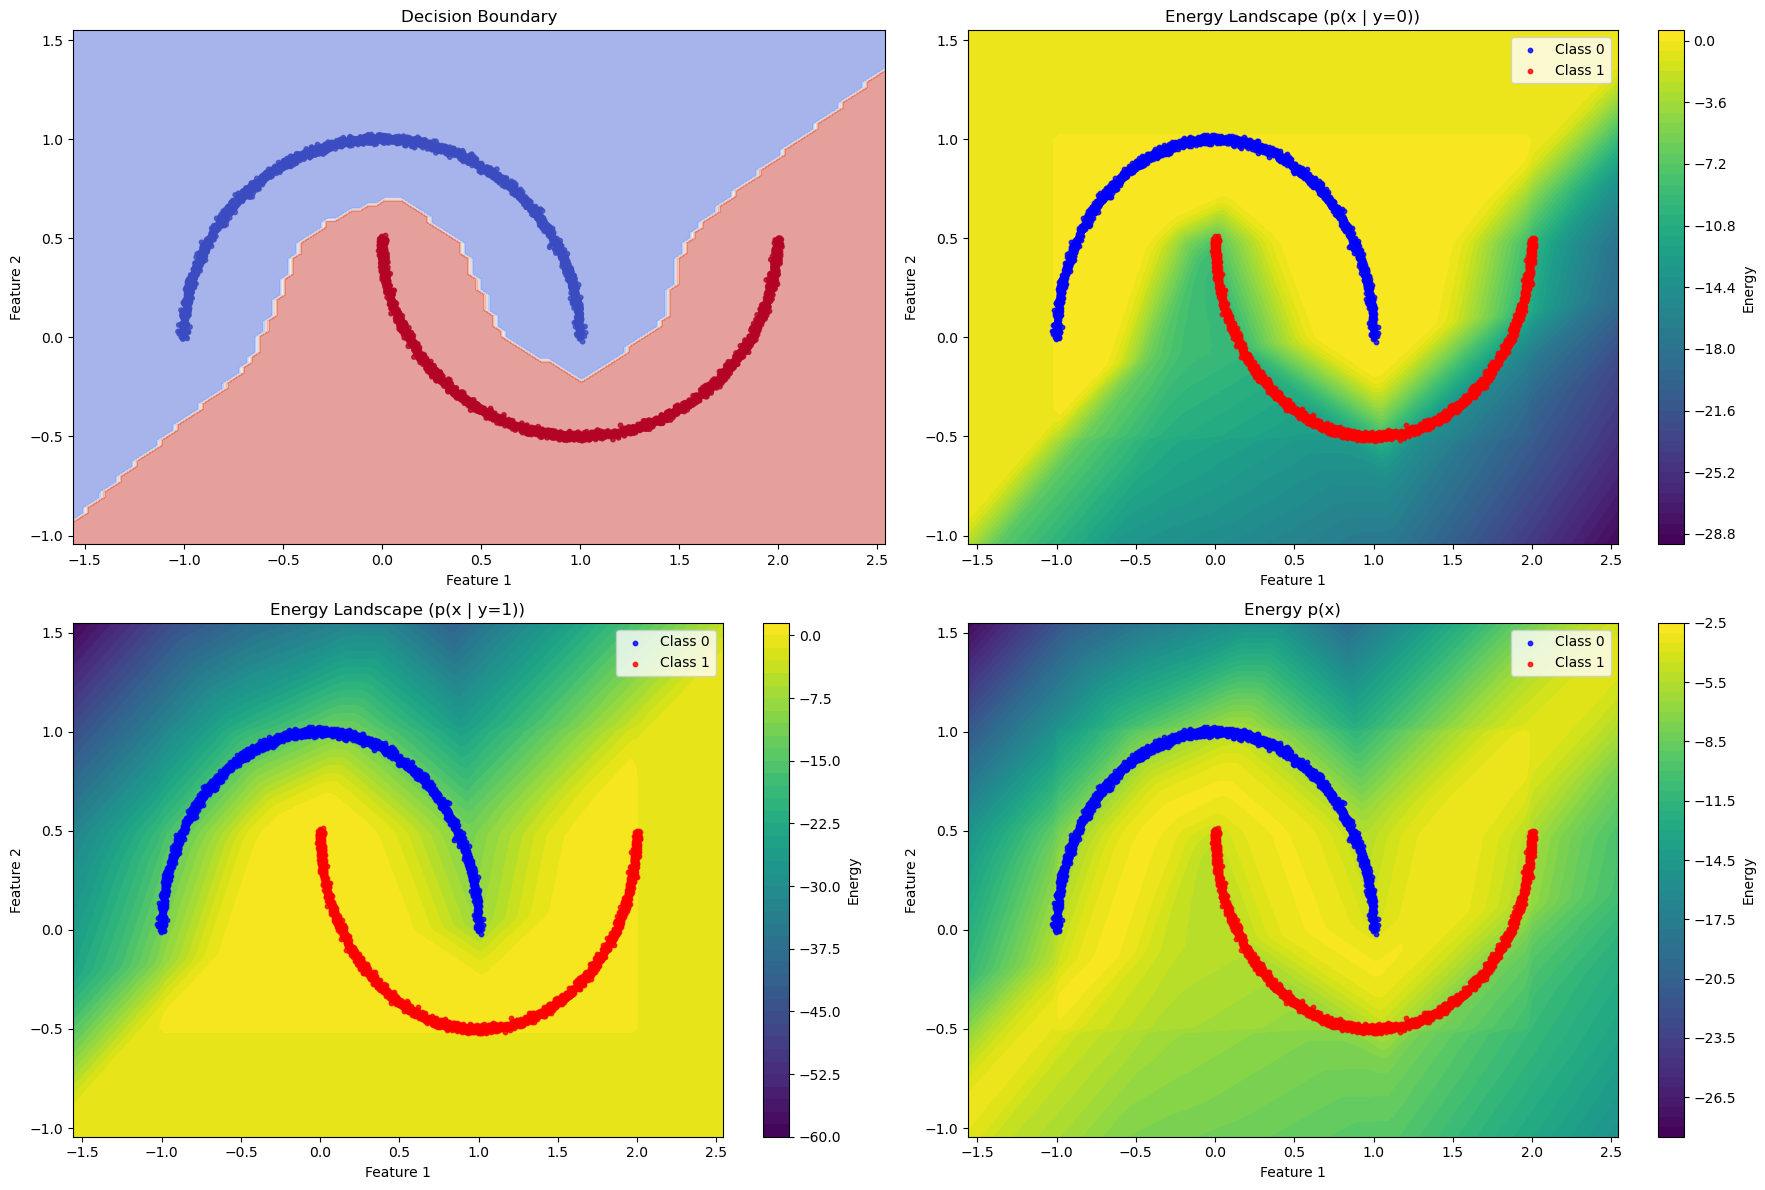

In [11]:
X, y = dataset.tensors
# Plot the decision boundary and energy landscape
plt.figure(figsize=(18, 12))

# Plot decision boundary
plt.subplot(2, 2, 1)
plt.contourf(xx, yy, predictions, alpha=0.5, cmap="coolwarm")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=10, alpha=0.8)
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot energy landscape for class 0
plt.subplot(2, 2, 2)
plt.contourf(xx, yy, energy_0, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="Class 1")
plt.title("Energy Landscape (p(x | y=0))")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Plot energy landscape for class 0
plt.subplot(2, 2, 3)
plt.contourf(xx, yy, energy_1, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="Class 1")
plt.title("Energy Landscape (p(x | y=1))")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Plot energy landscape for class 0
plt.subplot(2, 2, 4)
plt.contourf(xx, yy, energy, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="Class 1")
plt.title("Energy p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()

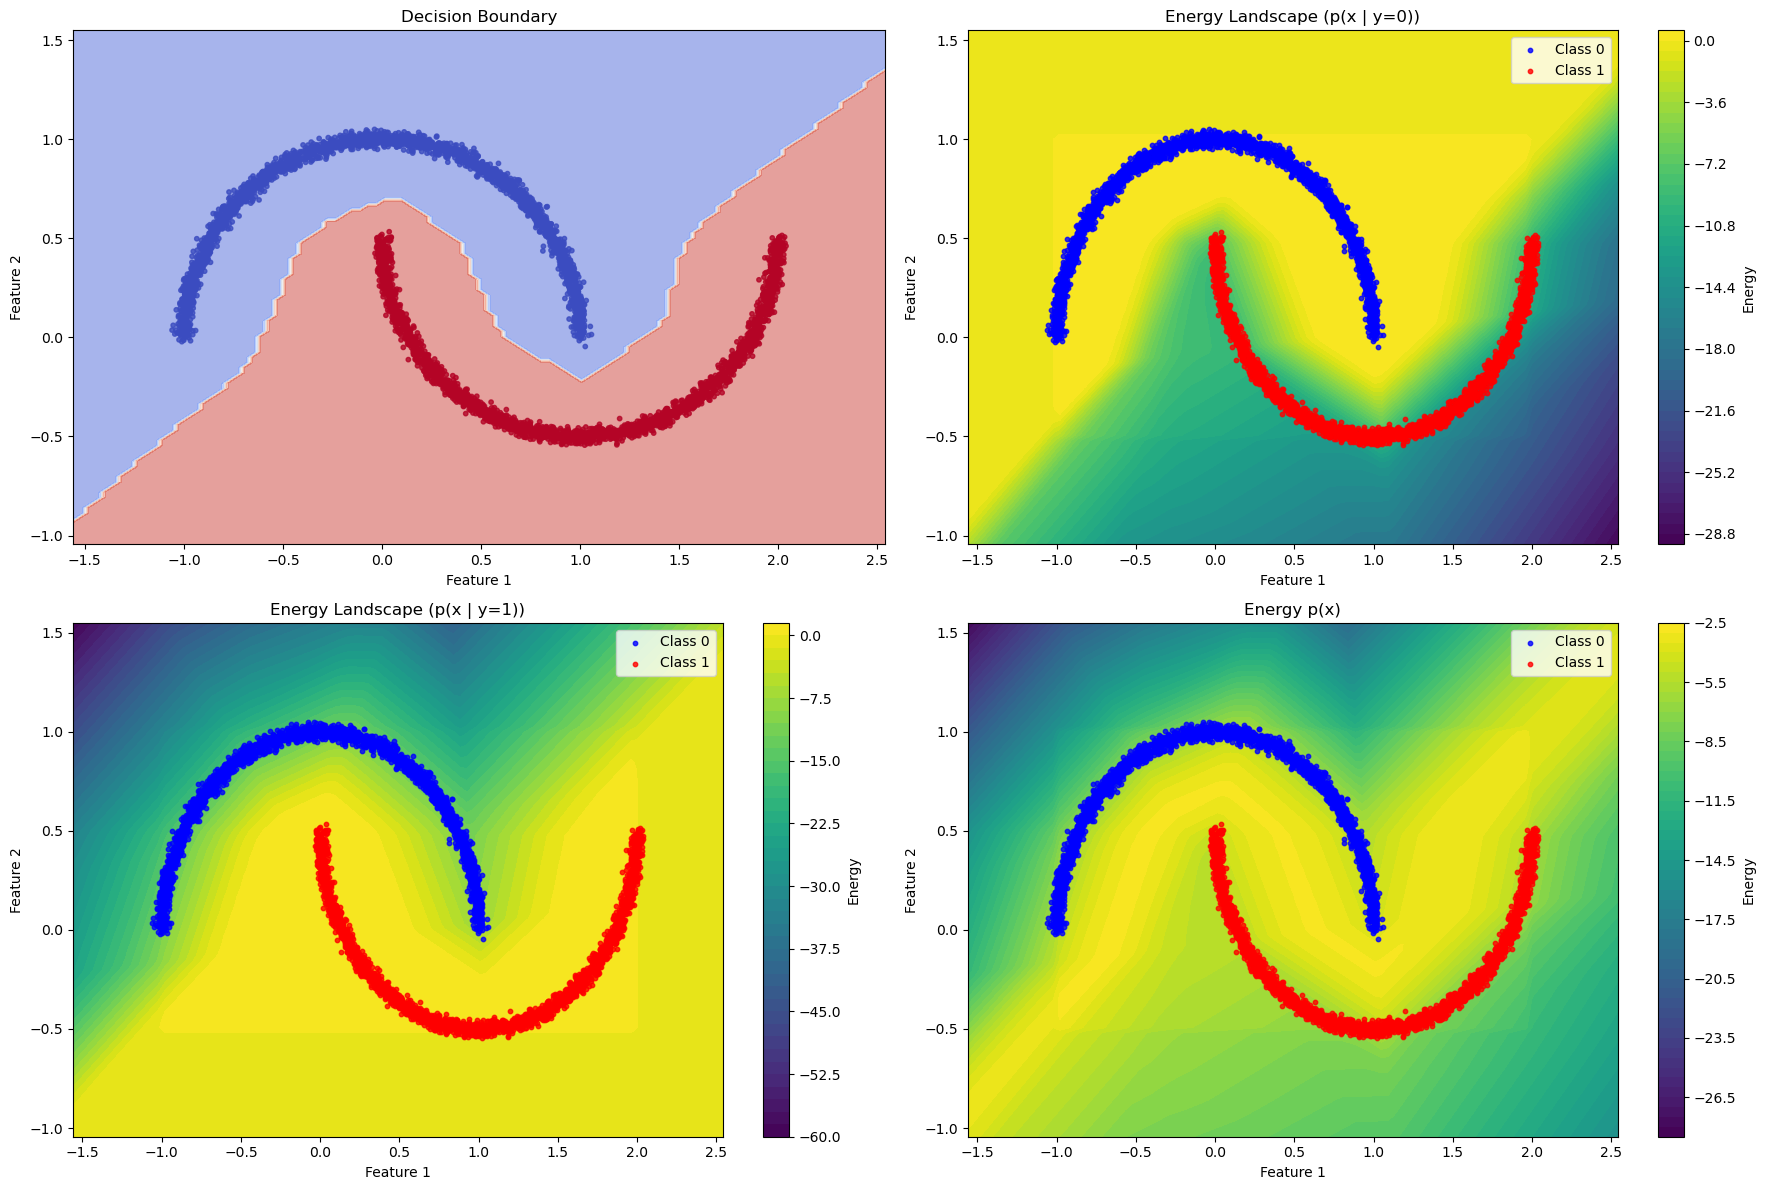

In [12]:
X, y = surrogate_dataset.tensors

# Plot the decision boundary and energy landscape
plt.figure(figsize=(18, 12))

# Plot decision boundary
plt.subplot(2, 2, 1)
plt.contourf(xx, yy, predictions, alpha=0.5, cmap="coolwarm")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=10, alpha=0.8)
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot energy landscape for class 0
plt.subplot(2, 2, 2)
plt.contourf(xx, yy, energy_0, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="Class 1")
plt.title("Energy Landscape (p(x | y=0))")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Plot energy landscape for class 0
plt.subplot(2, 2, 3)
plt.contourf(xx, yy, energy_1, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="Class 1")
plt.title("Energy Landscape (p(x | y=1))")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Plot energy landscape for class 0
plt.subplot(2, 2, 4)
plt.contourf(xx, yy, energy, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="Class 1")
plt.title("Energy p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Define the min and max values for each feature
min_values = torch.tensor([[-1, -0.5]])  # Minimum for each feature
max_values = torch.tensor([[2, 1]])  # Maximum for each feature

# Concatenate min and max values along the last dimension
range_tensor = torch.stack([min_values, max_values], dim=-1).to(device)
gen_sample_loader = sample_from_exact_marginal(model, 500, [2], 256, input_range=[-0.5, 1], range_tensor=range_tensor, range_penalty=2)

Generating samples with size [2]...
#########################################
sample 1 generated
#########################################
#########################################
sample 2 generated
#########################################
#########################################
sample 3 generated
#########################################
#########################################
sample 4 generated
#########################################
#########################################
sample 5 generated
#########################################
#########################################
sample 6 generated
#########################################
#########################################
sample 7 generated
#########################################
#########################################
sample 8 generated
#########################################
#########################################
sample 9 generated
#########################################
#####################################

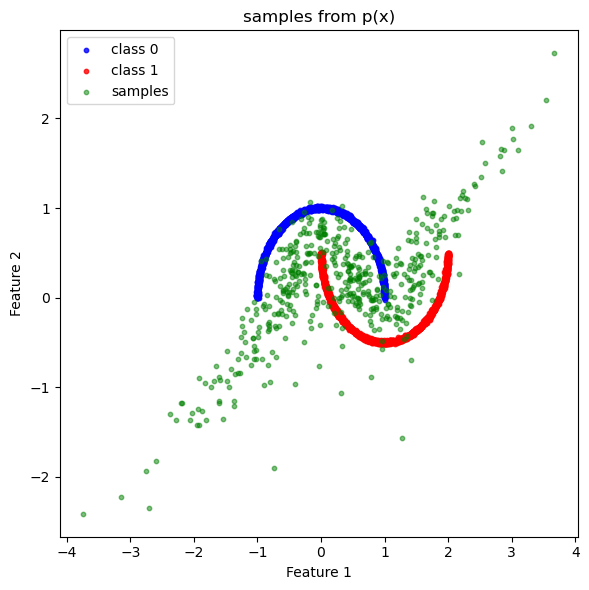

In [14]:
(samples, ) = gen_sample_loader.dataset.tensors
X, y = dataset.tensors
# Plot energy landscape for class 0
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="class 1")
plt.scatter(samples[:, 0], samples[:, 1], label="samples", s=10, alpha=0.5, color="green")
plt.title("samples from p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
ftheta, kl_distance = estimate_marginal_kl_distance(surrogate_loader, gen_sample_loader, device)

Epoch 1, DV KL: 0.0095
Epoch 2, DV KL: 0.0454
Epoch 3, DV KL: 0.0763
Epoch 4, DV KL: 0.1050
Epoch 5, DV KL: 0.1328
Epoch 6, DV KL: 0.1600
Epoch 7, DV KL: 0.1876
Epoch 8, DV KL: 0.2163
Epoch 9, DV KL: 0.2458
Epoch 10, DV KL: 0.2764
Epoch 11, DV KL: 0.3049
Epoch 12, DV KL: 0.3340
Epoch 13, DV KL: 0.3624
Epoch 14, DV KL: 0.3897
Epoch 15, DV KL: 0.4194
Epoch 16, DV KL: 0.4430
Epoch 17, DV KL: 0.4703
Epoch 18, DV KL: 0.4965
Epoch 19, DV KL: 0.5205
Epoch 20, DV KL: 0.5442
Epoch 21, DV KL: 0.5624
Epoch 22, DV KL: 0.5888
Epoch 23, DV KL: 0.6093
Epoch 24, DV KL: 0.6273
Epoch 25, DV KL: 0.6462
Epoch 26, DV KL: 0.6634
Epoch 27, DV KL: 0.6801
Epoch 28, DV KL: 0.6988
Epoch 29, DV KL: 0.7139
Epoch 30, DV KL: 0.7290
Epoch 31, DV KL: 0.7433
Epoch 32, DV KL: 0.7607
Epoch 33, DV KL: 0.7719
Epoch 34, DV KL: 0.7874
Epoch 35, DV KL: 0.7980
Epoch 36, DV KL: 0.8071
Epoch 37, DV KL: 0.8204
Epoch 38, DV KL: 0.8358
Epoch 39, DV KL: 0.8479
Epoch 40, DV KL: 0.8646
Epoch 41, DV KL: 0.8745
Epoch 42, DV KL: 0.8856
E

In [16]:
rmodel = MLP()
rmodel = rmodel.to(device)
optimizer = torch.optim.Adam(rmodel.parameters(), lr=0.01)
train(retain_loader, test_loader, rmodel, criterion, optimizer, num_epoch=100, device=device)
log_eval(rmodel, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)
rmodel = rmodel.to('cpu')

eval: 100%|██████████| 20/20 [00:00<00:00, 326.51batch/s, acc=1, loss=2.2e-5]


train: 1.0, test: 1.0, retain: 1.0, forget: 1.0, surrogate:1.0


In [17]:
smodel = MLP()
smodel = smodel.to(device)
optimizer = torch.optim.Adam(smodel.parameters(), lr=0.01)
train(surrogate_loader, test_loader, smodel, criterion, optimizer, num_epoch=100, device=device)
log_eval(smodel, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)
smodel = smodel.to('cpu')

eval: 100%|██████████| 20/20 [00:00<00:00, 356.53batch/s, acc=1, loss=1.54e-5]

train: 1.0, test: 1.0, retain: 1.0, forget: 1.0, surrogate:1.0


In [18]:
umodel = forget(model, train_loader, forget_loader, forget_loader, criterion, device, eps=5 * (math.e ** 3), delta=1)
log_eval(umodel, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)
umodel = umodel.to('cpu')

eval: 100%|██████████| 20/20 [00:00<00:00, 352.01batch/s, acc=1, loss=2.8e-5]

train: 1.0, test: 1.0, retain: 1.0, forget: 1.0, surrogate:1.0


In [19]:
smodel = smodel.to(device)
usmodel = forget(model, surrogate_loader, forget_loader, forget_loader, criterion, device, eps=5 * (math.e ** 3), delta=1, surr=True,
                 known=True, surr_loader=surrogate_loader, surr_model=smodel, kl_distance=kl_distance)
log_eval(usmodel, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)
usmodel = usmodel.to('cpu')
smodel = smodel.to('cpu')

eval: 100%|██████████| 20/20 [00:00<00:00, 376.79batch/s, acc=1, loss=3.96e-5]

train: 1.0, test: 1.0, retain: 1.0, forget: 1.0, surrogate:1.0
